In [89]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


train_df = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/Google_Stock_Price_Train.csv')
test_df = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/Google_Stock_Price_Test.csv')


# transform date to datetime type as index
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

# set all features
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# remove comma
train_df[features] = train_df[features].replace({',': ''}, regex=True).astype(float)
test_df[features] = test_df[features].replace({',': ''}, regex=True).astype(float)


# data normalization, create dataframe for data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])
train_scaled_df = pd.DataFrame(train_scaled, columns=features, index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=features, index=test_df.index)

# split train,val sets in 8/2
train_size = int(len(train_scaled_df) * 0.8)
train_data = train_scaled_df[:train_size]
val_data = train_scaled_df[train_size:]

# use past N days to predict next M dayts, create time series
def create_dataset(data, N=30, M=1):
    X, y = [], []
    for i in range(N, len(data) - M + 1):
        X.append(data[i-N:i])  
        y.append(data[i:i+M, 3]) # predict next M days close price
    return np.array(X), np.array(y)
    
X_train, y_train = create_dataset(train_data.values)
X_val, y_val = create_dataset(val_data.values)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (976, 30, 5)
y_train shape: (976, 1)
X_val shape: (222, 30, 5)
y_val shape: (222, 1)


In [51]:
print(test_df.info())
print(f"Scaler data_min: {scaler.data_min_}")
print(f"Scaler data_max: {scaler.data_max_}")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2017-01-03 to 2017-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    20 non-null     float64
 1   High    20 non-null     float64
 2   Low     20 non-null     float64
 3   Close   20 non-null     float64
 4   Volume  20 non-null     float64
dtypes: float64(5)
memory usage: 960.0 bytes
None
Scaler data_min: [   744.59    754.      737.03    747.92 587400.  ]
Scaler data_max: [8.0040e+02 8.0438e+02 7.9401e+02 7.9785e+02 3.0179e+06]


In [47]:
# Train LSTM model
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error
import math

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(lstm_out[:, -1, :])  # only output last time step used
        
        return out

# convert to pytorch tensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.Tensor(X_train).to(device)
y_train_tensor = torch.Tensor(y_train).to(device)
X_val_tensor = torch.Tensor(X_val).to(device)
y_val_tensor = torch.Tensor(y_val).to(device)
y_train_tensor = y_train_tensor.squeeze()
y_val_tensor = y_val_tensor.squeeze()


# set LSTM model para.
input_size = 5  # features
hidden_size = 64  # LSTM hidden layer size
num_layers = 2  # LSTM layer size
output_size = 1  # predict close
num_epochs = 100  # training epoch
batch_size = 32  # batch size
learning_rate = 0.001  # leanring rate


# set loss function and optimizer, init model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    model.train()  

    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size].unsqueeze(1)
        
        # zero gradient
        optimizer.zero_grad()
        
        # forward
        outputs = model(batch_X)
        
        # cal loss
        loss = criterion(outputs, batch_y)
        
        # backward
        loss.backward()
        
        # update weight
        optimizer.step()
    
    # every 10 epoch output 
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


# val model
model.eval() 
with torch.no_grad():  
    val_outputs = model(X_val_tensor)
    val_y = y_val_tensor.unsqueeze(1)  
    val_loss = criterion(val_outputs, val_y)
    print(f'Validation Loss: {val_loss.item():.4f}')


Epoch [10/100], Loss: 0.0139
Epoch [20/100], Loss: 0.0009
Epoch [30/100], Loss: 0.0005
Epoch [40/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0033
Epoch [70/100], Loss: 0.0044
Epoch [80/100], Loss: 0.0030
Epoch [90/100], Loss: 0.0026
Epoch [100/100], Loss: 0.0024
Validation Loss: 0.0015


In [48]:
# test lstm mse,rmse

model.eval()
with torch.no_grad():

    test_outputs = model(X_val_tensor)
    mse = mean_squared_error(y_val_tensor.cpu(), test_outputs.cpu())
    rmse = math.sqrt(mse)
    
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')


MSE: 0.0015
RMSE: 0.0384


In [65]:
# predict next 30 days, from 1/1 to 1/31 2017, compare with acutal close data

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np


data_df = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/RealComparedatasets.csv')
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df.set_index('Date', inplace=True)

# only scaler close column, normalizaed 
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data_df[features] = data_df[features].replace({',': ''}, regex=True).astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_df[features])
close_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = close_scaler.fit_transform(data_df[['Close']])
data_df['Scaled_Close'] = scaled_close


N = 30
X_input = scaled_data[-N:].reshape(1, N, len(features))  # reshape to (1, 30, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_input_tensor = torch.Tensor(X_input).to(device)


model.eval()

with torch.no_grad():

    predicted_price = model(X_input_tensor)
    # print(f"Predicted scaled price: {predicted_price}")

    predicted_price = predicted_price.cpu().numpy()
    print(f"Predicted price in numpy array: {predicted_price}")

    # only fill close column
    predicted_price_with_zeros = np.zeros((1, len(features)))
    predicted_price_with_zeros[0, -1] = predicted_price[0, -1]  # only fill close column
    # print(f"Price with zeros for inverse transformation: {predicted_price_with_zeros}")

    # manual denormalization
    close_min = close_scaler.data_min_[0]
    close_max = close_scaler.data_max_[0]
    predicted_close_rescaled = close_min + (predicted_price[0, -1] * (close_max - close_min))
    print(f"Rescaled Close price (manually): {predicted_close_rescaled}")

    print(f"Predicted Close price for 2017-01-01: {predicted_close_rescaled:.2f}")


Predicted price in numpy array: [[0.4504939]]
Rescaled Close price (manually): 770.4131605252624
Predicted Close price for 2017-01-01: 770.41


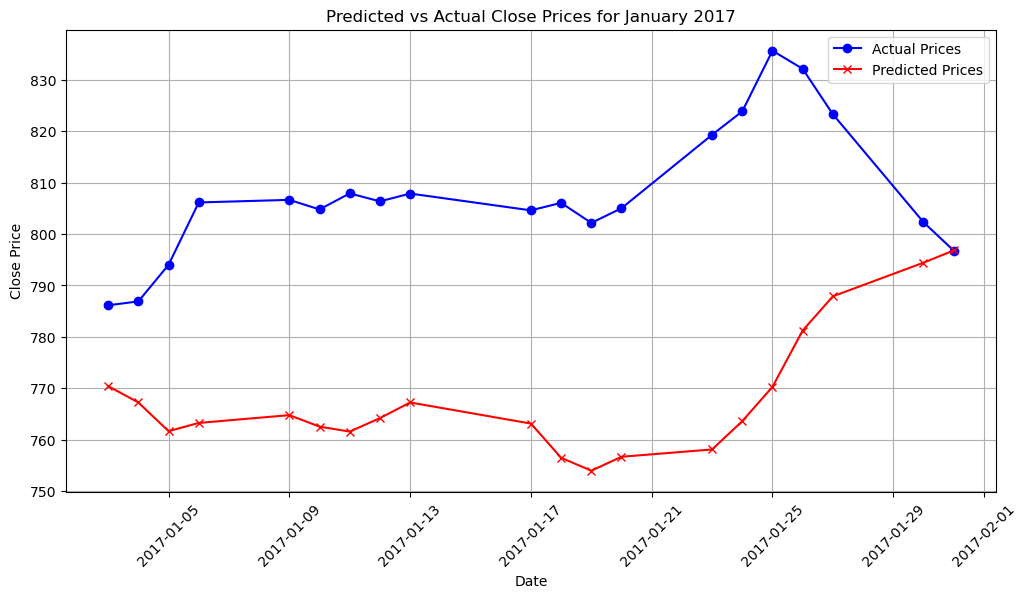

In [71]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
import matplotlib.pyplot as plt

# load past 30 days data from 2016/12/1
data_df = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/RealComparedatasets.csv')
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df.set_index('Date', inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume']
data_df[features] = data_df[features].replace({',': ''}, regex=True).astype(float)

# minMaxScaler 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_df[features])

# normalize close column
close_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = close_scaler.fit_transform(data_df[['Close']])
data_df['Scaled_Close'] = scaled_close

N = 30
X_input = scaled_data[-N:].reshape(1, N, len(features))  # reshape to (1, 30, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_input_tensor = torch.Tensor(X_input).to(device)


model.eval()

predicted_prices = []
with torch.no_grad():
    for i in range(31):  # predict from 1/2 to 1/31
       
        predicted_price = model(X_input_tensor)

        # only fill close column
        predicted_price = predicted_price.cpu().numpy()
        predicted_price_with_zeros = np.zeros((1, len(features)))
        predicted_price_with_zeros[0, -1] = predicted_price[0, -1]  

        # hand denormalization
        close_min = close_scaler.data_min_[0]
        close_max = close_scaler.data_max_[0]
        predicted_close_rescaled = close_min + (predicted_price[0, -1] * (close_max - close_min))

        predicted_prices.append(predicted_close_rescaled)

        # update prediction
        X_input = np.roll(X_input, -1, axis=1)  # update window
        X_input[0, -1, -1] = predicted_price[0, -1]  
        X_input_tensor = torch.Tensor(X_input).to(device)

# load test datasets
test_data = pd.read_csv('D:/Study/7318/a3/Recurrent-Neural-Networks-for-Stock-Price-Prediction/datasets/Google_Stock_Price_Test.csv')
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date', inplace=True)

# get actual close column
actual_prices = test_data['Close'].values

# plot cruve
predicted_prices_trimmed = predicted_prices[:len(test_data.index)]
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, actual_prices, label='Actual Prices', color='blue', marker='o')
plt.plot(test_data.index, predicted_prices_trimmed, label='Predicted Prices', color='red', marker='x')
plt.title('Predicted vs Actual Close Prices for January 2017')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [75]:
# make form and Match
import pandas as pd

results = pd.DataFrame({
    'Date': test_data.index,
    'Predicted Close': predicted_prices[:len(test_data.index)], 
    'Actual Close': actual_prices
})

results['Trend Match'] = results.apply(
    lambda row: 'Match' if (row['Predicted Close'] > row['Actual Close'] and row.name > 0 and 
                            results.iloc[row.name - 1]['Actual Close'] < row['Actual Close']) or 
                           (row['Predicted Close'] < row['Actual Close'] and row.name > 0 and 
                            results.iloc[row.name - 1]['Actual Close'] > row['Actual Close'])
                 else 'Mismatch', 
    axis=1
)

print(results)

matches = results['Trend Match'].value_counts().get('Match', 0)
mismatches = results['Trend Match'].value_counts().get('Mismatch', 0)
total = len(results)
accuracy = matches / total * 100

print(f"\nTrend Match Analysis:")
print(f"Total Predictions: {total}")
print(f"Matches: {matches}")
print(f"Mismatches: {mismatches}")
print(f"Trend Match Accuracy: {accuracy:.2f}%")


         Date  Predicted Close  Actual Close Trend Match
0  2017-01-03       770.413161        786.14    Mismatch
1  2017-01-04       767.229108        786.90    Mismatch
2  2017-01-05       761.649140        794.02    Mismatch
3  2017-01-06       763.252756        806.15    Mismatch
4  2017-01-09       764.764742        806.65    Mismatch
5  2017-01-10       762.535615        804.79       Match
6  2017-01-11       761.564866        807.91    Mismatch
7  2017-01-12       764.182236        806.36       Match
8  2017-01-13       767.231379        807.88    Mismatch
9  2017-01-17       763.126258        804.61       Match
10 2017-01-18       756.476463        806.07    Mismatch
11 2017-01-19       753.952791        802.17       Match
12 2017-01-20       756.668908        805.02    Mismatch
13 2017-01-23       758.088418        819.31    Mismatch
14 2017-01-24       763.599672        823.87    Mismatch
15 2017-01-25       770.267401        835.67    Mismatch
16 2017-01-26       781.226036 

In [77]:
# GRU model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# convert to pytorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)


batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# init GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # last time step output
        return out

# set para.
input_size = len(features) 
hidden_size = 50  
output_size = y_train.shape[1]  
num_layers = 2  
learning_rate = 0.001
num_epochs = 100

# loss function, optimizer
model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# save model
torch.save(model.state_dict(), "gru_model.pth")


Epoch [1/100], Train Loss: 0.0755, Val Loss: 0.0042
Epoch [2/100], Train Loss: 0.0307, Val Loss: 0.0009
Epoch [3/100], Train Loss: 0.0066, Val Loss: 0.0009
Epoch [4/100], Train Loss: 0.0034, Val Loss: 0.0004
Epoch [5/100], Train Loss: 0.0023, Val Loss: 0.0004
Epoch [6/100], Train Loss: 0.0021, Val Loss: 0.0005
Epoch [7/100], Train Loss: 0.0021, Val Loss: 0.0004
Epoch [8/100], Train Loss: 0.0018, Val Loss: 0.0003
Epoch [9/100], Train Loss: 0.0018, Val Loss: 0.0004
Epoch [10/100], Train Loss: 0.0017, Val Loss: 0.0006
Epoch [11/100], Train Loss: 0.0017, Val Loss: 0.0003
Epoch [12/100], Train Loss: 0.0016, Val Loss: 0.0002
Epoch [13/100], Train Loss: 0.0016, Val Loss: 0.0003
Epoch [14/100], Train Loss: 0.0015, Val Loss: 0.0002
Epoch [15/100], Train Loss: 0.0014, Val Loss: 0.0003
Epoch [16/100], Train Loss: 0.0015, Val Loss: 0.0002
Epoch [17/100], Train Loss: 0.0013, Val Loss: 0.0003
Epoch [18/100], Train Loss: 0.0013, Val Loss: 0.0002
Epoch [19/100], Train Loss: 0.0013, Val Loss: 0.0002
Ep

In [78]:
# test accuracy

model.eval()
with torch.no_grad():

    test_outputs = model(X_val_tensor)
    mse = mean_squared_error(y_val_tensor.cpu(), test_outputs.cpu())
    rmse = math.sqrt(mse)
    
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')


MSE: 0.0002
RMSE: 0.0123


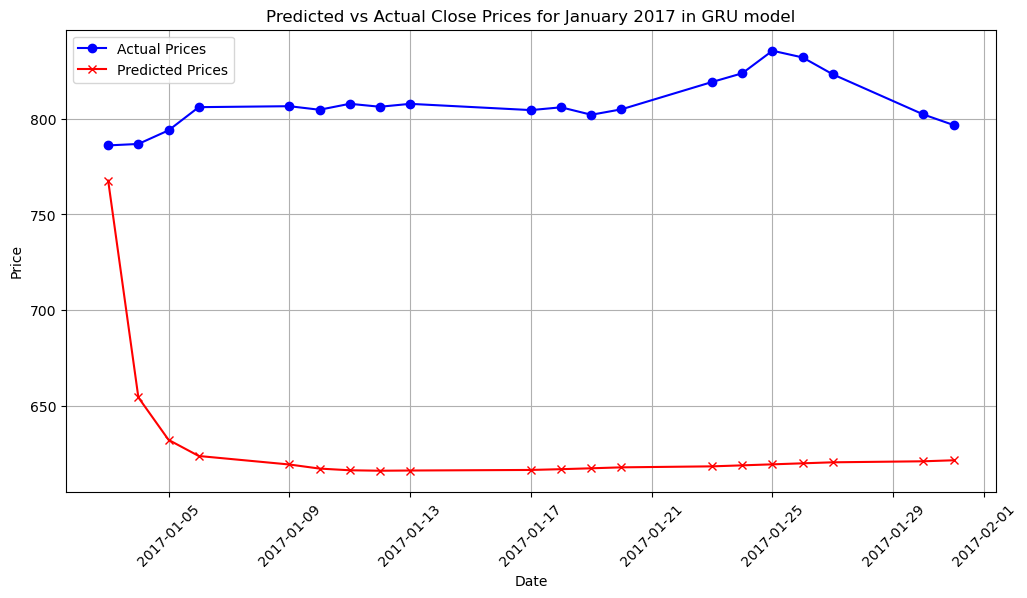

In [85]:
import matplotlib.pyplot as plt


N = 30
X_input = train_scaled_df[-N:].values  # (30, 5)
X_input = X_input.reshape(1, N, len(features))  # reshape to (1, 30, 5)

# save prediction
X_input_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)
predicted_prices = []

model.eval()
with torch.no_grad():
    for _ in range(31):  
        # get prediction close column
        predicted_scaled = model(X_input_tensor)
        predicted_close_scaled = predicted_scaled.cpu().numpy()[0, -1]
        
        # hand denormorlization
        close_min = scaler.data_min_[3]  # forth column Close min
        close_max = scaler.data_max_[3]  # forth column Close max
        predicted_close = close_min + (predicted_close_scaled * (close_max - close_min))
        
        # save
        predicted_prices.append(predicted_close)
        
        # update
        next_input = X_input[0, 1:, :]  
        next_input = np.append(next_input, [[0, 0, 0, predicted_scaled.cpu().numpy()[0, -1], 0]], axis=0) 
        X_input = next_input.reshape(1, N, len(features))  
        X_input_tensor = torch.tensor(X_input, dtype=torch.float32).to(device)


# only compare first 20 days(test data only gets)
predicted_prices_20 = predicted_prices[:20]
actual_prices_20 = actual_prices[:20]
actual_dates_20 = actual_dates[:20]

# plot
plt.figure(figsize=(12, 6))
plt.plot(actual_dates_20, actual_prices_20, label='Actual Prices', color='blue', marker='o') 
plt.plot(actual_dates_20, predicted_prices_20, label='Predicted Prices', color='red', marker='x') 
plt.title('Predicted vs Actual Close Prices for January 2017 in GRU model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [88]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame({
    'Date': test_df.index[:len(predicted_prices)], 
    'Predicted Close': predicted_prices[:len(test_df.index)], 
    'Actual Close': actual_prices[:len(test_df.index)]  
})

results['Trend Match'] = results.apply(
    lambda row: 'Match' if (row['Predicted Close'] > row['Actual Close'] and row.name > 0 and 
                            results.iloc[row.name - 1]['Actual Close'] < row['Actual Close']) or 
                           (row['Predicted Close'] < row['Actual Close'] and row.name > 0 and 
                            results.iloc[row.name - 1]['Actual Close'] > row['Actual Close'])
                 else 'Mismatch', 
    axis=1
)


print(results)

matches = results['Trend Match'].value_counts().get('Match', 0)
mismatches = results['Trend Match'].value_counts().get('Mismatch', 0)
total = len(results)
accuracy = matches / total * 100

print(f"\nTrend Match Analysis:")
print(f"Total Predictions: {total}")
print(f"Matches: {matches}")
print(f"Mismatches: {mismatches}")
print(f"Trend Match Accuracy: {accuracy:.2f}%")


         Date  Predicted Close  Actual Close Trend Match
0  2017-01-03       767.726434        786.14    Mismatch
1  2017-01-04       654.316989        786.90    Mismatch
2  2017-01-05       632.100852        794.02    Mismatch
3  2017-01-06       623.668718        806.15    Mismatch
4  2017-01-09       619.222372        806.65    Mismatch
5  2017-01-10       617.085626        804.79       Match
6  2017-01-11       616.200971        807.91    Mismatch
7  2017-01-12       615.964475        806.36       Match
8  2017-01-13       616.072797        807.88    Mismatch
9  2017-01-17       616.369909        804.61       Match
10 2017-01-18       616.772878        806.07    Mismatch
11 2017-01-19       617.236052        802.17       Match
12 2017-01-20       617.733373        805.02    Mismatch
13 2017-01-23       618.249659        819.31    Mismatch
14 2017-01-24       618.775893        823.87    Mismatch
15 2017-01-25       619.306668        835.67    Mismatch
16 2017-01-26       619.838741 

In [94]:
# train vanilla RNN model
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# init vanilla model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last output
        return out

# Set para.
input_size = len(features)  
hidden_size = 64  
output_size = 1  
epoch = 100
learning_rate = 0.001

# loss function and optimizer
model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train
for e in range(epoch):
    model.train()
    
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    
    loss = criterion(outputs, y_train_tensor)
    
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 10 == 0:
        print(f"Epoch [{e+1}/{epoch}], Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    mse = mean_squared_error(y_val_tensor.cpu(), val_outputs.cpu())
    rmse = math.sqrt(mse)

    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')

Epoch [10/100], Loss: 0.0487
Epoch [20/100], Loss: 0.0202
Epoch [30/100], Loss: 0.0034
Epoch [40/100], Loss: 0.0028
Epoch [50/100], Loss: 0.0025
Epoch [60/100], Loss: 0.0022
Epoch [70/100], Loss: 0.0021
Epoch [80/100], Loss: 0.0020
Epoch [90/100], Loss: 0.0020
Epoch [100/100], Loss: 0.0019
MSE: 0.0003
RMSE: 0.0173
